# EdU-RB image Analysis
Pulling Images from screening data from Omero.
Segmentation via Stardist.
Display a sample image to check segmentation.
Loop through the plate and collect Features from Feature list (label, area, mean and max intensities)
Return Padnas dataframe with single cell data sorted by row and column.
Filter out smallest objects (<=50 pixels area)
Save as CSV file in Datafolder

In [1]:
#Define Variables
# 1) Name of Datafolder -> Experiment
Experiment='2200525_XM_EdUexp02'
# 2) Location where to save Data -> PD
PD='/Users/hh65/Desktop'
# 3) Sample Image ID -> ID
ID=301826
# 4) Plate ID -> PlateID
PlateID=767

In [2]:
# Imports and Functions
%run ../Functions-Module.ipynb
import os
from omero.gateway import BlitzGateway
import pandas as pd

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
import matplotlib.pyplot as plt

from stardist.models import StarDist2D
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Make folder to save output data in chosen directory

D_PATH = os.path.join(PD, Experiment)
os.makedirs(D_PATH, exist_ok=True)



Found model '2D_versatile_fluo' for 'StarDist2D'.
Metal device set to: Apple M1 Pro


2022-06-06 16:50:30.997147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-06 16:50:30.997399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [3]:
# Connecting to server

conn = BlitzGateway('helfrid', 'Omero_21', host='ome2.hpc.susx.ac.uk')
conn.connect()




True

In [4]:

object= conn.getObject("Image", ID)
pixels=object.getPrimaryPixels()

imgDAPI=pixels.getPlane(0,0,0)
segmented_cells, cell_number=Stardist_Segmentation(imgDAPI)
Napari_Display(imgDAPI, segmented_cells, cell_number)

2022-06-06 16:51:11.821929: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-06 16:51:11.922666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
numeric.py (2446): elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [6]:
# Loop through the Well and analyse Images.Return a dataframe df_sc with singel cell data
from tqdm import tqdm
Feature_list=['label','area','max_intensity','mean_intensity']
df_sc=pd.DataFrame()
plate = conn.getObject("Plate", PlateID)
plate_name= plate.getName()
wells = list(plate.listChildren())
for well in tqdm(wells):
    print (well.id)
    df=pd.DataFrame()
    for number, image in enumerate(well.listChildren()):
        image = well.getImage(number)
        pixels=image.getPrimaryPixels()
        DAPI=pixels.getPlane(0,0,0)
        EdU=pixels.getPlane(0,1,0)
        RB=pixels.getPlane(0,2,0)

        segmented, cell_number = Stardist_Segmentation(DAPI)
        DAPI_data=get_features(segmented, DAPI, Feature_list)
        DAPI_data.rename(columns = {'max_intensity':'max_intensity_DAPI',
                                    'mean_intensity':'mean_intensity_DAPI'}, inplace = True)

        EdU_data=get_features(segmented, EdU, Feature_list)
        EdU_data.rename(columns = {'max_intensity':'max_intensity_EdU',
                                    'mean_intensity':'mean_intensity_EdU'}, inplace = True)
        RB_data=get_features(segmented, RB, Feature_list)
        RB_data.rename(columns = {'max_intensity':'max_intensity_RB',
                                    'mean_intensity':'mean_intensity_RB'}, inplace = True)
        df_merge_2 = pd.merge(DAPI_data, EdU_data, on=['label','area'])
        df_merge_3 = pd.merge(df_merge_2, RB_data, on=['label','area'])
        df=pd.concat([df,df_merge_3])
        df['column']=well.column
        df['row']=well.row
        df['integrated_int_DAPI']=df['mean_intensity_DAPI']*df['area']
    df_sc=pd.concat([df_sc,df])

df_sc.info()

  0%|          | 0/72 [00:00<?, ?it/s]

5723


  1%|▏         | 1/72 [00:20<23:48, 20.12s/it]

5722


  3%|▎         | 2/72 [00:42<24:43, 21.20s/it]

5721


  4%|▍         | 3/72 [01:02<24:01, 20.90s/it]

5720


  6%|▌         | 4/72 [01:25<24:35, 21.70s/it]

5719


  7%|▋         | 5/72 [01:46<24:03, 21.54s/it]

5718


  8%|▊         | 6/72 [02:08<23:34, 21.44s/it]

5717


 10%|▉         | 7/72 [02:30<23:41, 21.87s/it]

5716


 11%|█         | 8/72 [02:50<22:33, 21.14s/it]

5715


 12%|█▎        | 9/72 [03:10<21:57, 20.91s/it]

5714


 14%|█▍        | 10/72 [03:32<21:45, 21.06s/it]

5713


 15%|█▌        | 11/72 [03:53<21:38, 21.28s/it]

5712


 17%|█▋        | 12/72 [04:15<21:22, 21.37s/it]

5711


 18%|█▊        | 13/72 [04:37<21:10, 21.53s/it]

5710


 19%|█▉        | 14/72 [04:57<20:31, 21.24s/it]

5709


 21%|██        | 15/72 [05:17<19:38, 20.67s/it]

5708


 22%|██▏       | 16/72 [05:37<19:04, 20.44s/it]

5707


 24%|██▎       | 17/72 [05:58<19:01, 20.75s/it]

5706


 25%|██▌       | 18/72 [06:19<18:39, 20.74s/it]

5705


 26%|██▋       | 19/72 [06:39<18:16, 20.68s/it]

5704


 28%|██▊       | 20/72 [07:02<18:30, 21.36s/it]

5703


 29%|██▉       | 21/72 [07:23<18:00, 21.19s/it]

5702


 31%|███       | 22/72 [07:45<17:55, 21.51s/it]

5701


 32%|███▏      | 23/72 [08:07<17:28, 21.40s/it]

5700


 33%|███▎      | 24/72 [08:27<16:54, 21.13s/it]

5699


 35%|███▍      | 25/72 [08:48<16:31, 21.11s/it]

5698


 36%|███▌      | 26/72 [09:10<16:19, 21.29s/it]

5697


 38%|███▊      | 27/72 [09:31<16:00, 21.35s/it]

5696


 39%|███▉      | 28/72 [09:51<15:17, 20.85s/it]

5695


 40%|████      | 29/72 [10:11<14:43, 20.54s/it]

5694


 42%|████▏     | 30/72 [10:31<14:16, 20.39s/it]

5693


 43%|████▎     | 31/72 [10:52<14:01, 20.53s/it]

5692


 44%|████▍     | 32/72 [11:11<13:30, 20.26s/it]

5691


 46%|████▌     | 33/72 [11:32<13:15, 20.40s/it]

5690


 47%|████▋     | 34/72 [11:54<13:07, 20.74s/it]

5689


 49%|████▊     | 35/72 [12:16<13:01, 21.13s/it]

5688


 50%|█████     | 36/72 [12:36<12:35, 20.99s/it]

5687


 51%|█████▏    | 37/72 [12:57<12:07, 20.79s/it]

5686


 53%|█████▎    | 38/72 [13:16<11:32, 20.37s/it]

5685


 54%|█████▍    | 39/72 [13:36<11:05, 20.18s/it]

5684


 56%|█████▌    | 40/72 [13:56<10:46, 20.21s/it]

5683


 57%|█████▋    | 41/72 [14:17<10:31, 20.38s/it]

5682


 58%|█████▊    | 42/72 [14:39<10:26, 20.90s/it]

5681


 60%|█████▉    | 43/72 [14:59<10:00, 20.71s/it]

5680


 61%|██████    | 44/72 [15:23<10:05, 21.64s/it]

5679


 62%|██████▎   | 45/72 [15:45<09:42, 21.59s/it]

5678


 64%|██████▍   | 46/72 [16:05<09:15, 21.35s/it]

5677


 65%|██████▌   | 47/72 [16:26<08:51, 21.27s/it]

5676


 67%|██████▋   | 48/72 [16:46<08:18, 20.78s/it]

5675


 68%|██████▊   | 49/72 [17:07<08:00, 20.89s/it]

5674


 69%|██████▉   | 50/72 [17:28<07:41, 20.97s/it]

5673


 71%|███████   | 51/72 [17:52<07:40, 21.92s/it]

5672


 72%|███████▏  | 52/72 [18:14<07:13, 21.67s/it]

5671


 74%|███████▎  | 53/72 [18:34<06:45, 21.34s/it]

5670


 75%|███████▌  | 54/72 [18:56<06:26, 21.48s/it]

5669


 76%|███████▋  | 55/72 [19:17<06:05, 21.48s/it]

5668


 78%|███████▊  | 56/72 [19:37<05:36, 21.04s/it]

5667


 79%|███████▉  | 57/72 [19:56<05:06, 20.44s/it]

5666


 81%|████████  | 58/72 [20:16<04:40, 20.05s/it]

5665


 82%|████████▏ | 59/72 [20:35<04:17, 19.77s/it]

5664


 83%|████████▎ | 60/72 [20:56<04:02, 20.18s/it]

5663


 85%|████████▍ | 61/72 [21:18<03:50, 20.91s/it]

5662


 86%|████████▌ | 62/72 [21:39<03:27, 20.71s/it]

5661


 88%|████████▊ | 63/72 [22:24<04:13, 28.21s/it]

5660


 89%|████████▉ | 64/72 [22:44<03:25, 25.66s/it]

5659


 90%|█████████ | 65/72 [23:06<02:51, 24.46s/it]

5658


 92%|█████████▏| 66/72 [23:25<02:17, 22.90s/it]

5657


 93%|█████████▎| 67/72 [23:50<01:56, 23.37s/it]

5656


 94%|█████████▍| 68/72 [24:14<01:34, 23.69s/it]

5655


 96%|█████████▌| 69/72 [24:37<01:10, 23.45s/it]

5654


 97%|█████████▋| 70/72 [24:58<00:45, 22.77s/it]

5653


 99%|█████████▊| 71/72 [25:18<00:22, 22.05s/it]

5652


100%|██████████| 72/72 [25:39<00:00, 21.39s/it]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322911 entries, 0 to 545
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   label                322911 non-null  int64  
 1   area                 322911 non-null  int64  
 2   max_intensity_DAPI   322911 non-null  float64
 3   mean_intensity_DAPI  322911 non-null  float64
 4   max_intensity_EdU    322911 non-null  float64
 5   mean_intensity_EdU   322911 non-null  float64
 6   max_intensity_RB     322911 non-null  float64
 7   mean_intensity_RB    322911 non-null  float64
 8   column               322911 non-null  int64  
 9   row                  322911 non-null  int64  
 10  integrated_int_DAPI  322911 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 29.6 MB


<AxesSubplot:title={'center':'All nuclei'}, xlabel='integrated_int_DAPI', ylabel='area'>

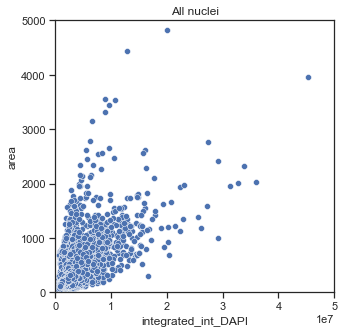

In [7]:
sns.set(style='ticks', font='Arial')
fig, ax = plt.subplots(ncols=1,figsize=(5, 5))
ax.set_xlim([0,50000000])
ax.set_ylim([0,5000])
plt.title('All nuclei')
sns.scatterplot(data=df_sc,x='integrated_int_DAPI',y='area')


In [8]:
df_gn=df_sc[df_sc['area']>50]
df_gn=df_gn.reset_index(drop=True)
df_gn=df_gn.sort_values(['row','column'])
csv_path=os.path.join(D_PATH, 'EdURB_test01.csv')
df_gn.to_csv(csv_path)